In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import geocoder
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('max_colwidth',200)
%matplotlib inline
import requests
import json
import urllib
from urllib.request import urlopen

def getGeoForAddress(address):
    add = urllib.parse.quote(address)
    addressUrl = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + '&key='
    res = requests.get(addressUrl)
    js = json.loads(res.text)
    if js.get('results'):
        lat = js.get('results')[0]['geometry']['location']['lat']
        lng = js.get('results')[0]['geometry']['location']['lng']
    else:
        lat = ''
        lng = ''
    return [lat, lng]
def ngram(text, n=3, pad=True):
    text = text.strip()
    if pad:
        text = " %s " % text
    return set([text[i:i+n] for i in range(len(text)-n+1)])
    
def create_ngram(text1, text2, n=3, pad=True):
    return ngram(text1, n=n, pad=pad), ngram(text2, n=n, pad=pad)

def tversky_index(text1, text2, a=None, b=None, q=3, pad=True):
    text1, text2 = create_ngram(text1, text2, n=q, pad=pad)
    agree_tot = len(text1.intersection(text2))
    v1 = len(text1) - agree_tot
    v2 = len(text2) - agree_tot
    
    if a != None and b != None:
        a = a/float(a+b)
        b = b/float(a+b)
    elif a <= 1.0 and a >= 0.0:
        b = 1-a
    elif b <= 1.0 and b >= 0.0:
        a = 1-b
    else:
        a = 0.5
        b = 0.5        
    return float(agree_tot)/(agree_tot+a*v1+b*v2)
# incoPat為申請人list
def fuzzy(incoPat,indus):
    corptype = ['有限','公司','责任','集团','股份','控股']
    text1 = incoPat
    text2 = indus
    incoPat_nor = []   
    for text in text1:
        for i in corptype:
            if i in text:
                text = re.sub(i,'',text)
        incoPat_nor.append(text)
    for i in corptype:
        if i in text2:
            text2 = re.sub(i,'',text2)
    similar = []
    for text in incoPat_nor:
        dice = tversky_index(text,text2, a=0.5, q=min(2,len(text),len(text2)), pad=False)
        if dice>0.7:
            similar.append([incoPat[incoPat_nor.index(text)],dice])
        else:
            pass
    if len(similar)>0:
        return similar[[k[1] for k in similar].index(max([i[1] for i in similar]))][0]
    else:
        return indus
city_code = pd.read_excel('C:/Users/user/Dropbox/paper/科技園區/China/省地縣碼對照.xls')
city_code = city_code[~city_code['代碼'].isnull()].drop(['标注','说明'],axis=1)
city_code['代碼_str'] = city_code['代碼'].apply(lambda x:str(int(x)))
city_code = city_code.drop('代碼',axis=1)

# 江西資料整合

In [2]:
patent_df = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江西.xls')

In [3]:
#for PC
patent_df = patent_df[patent_df['专利类型']=='发明授权']
patent_df = patent_df[patent_df['申请人地址'].map(lambda x:len(re.findall(r'\D+[\s\S]+',x)))==1]
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.findall(r'\D+[\s\S]+',x)[0])
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.sub(r"\s+", "",x))
patent_df_firm = patent_df[patent_df['申请人类型'].str.contains('企业')]
applicant = patent_df_firm['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
patent_df_firm = patent_df_firm.join(applicant)
patent_df_firm['類別'] = patent_df_firm['申请人类型'].map(lambda x:x.strip().split('  '))
patent_df_firm = patent_df_firm[~patent_df_firm['标题'].duplicated()]
patent_df_firm['申请人类型'] = patent_df_firm.apply(lambda x:x['類別'][0],axis=1)
patent_df_firm = patent_df_firm[patent_df_firm['申请人类型']=='企业'].sort_values('申请日')
patent_df_firm.drop(['類別','申请人'],axis=1,inplace=True)
patent_df_firm.rename(columns={'申请人2':'申请人'},inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']<datetime.datetime.strptime('2013-01-01','%Y-%m-%d')]
patent_df_firm.drop_duplicates('申请人地址', keep='last', inplace=True)
patent_df_firm.drop_duplicates('申请人', keep='last', inplace=True)


firm_df = pd.read_csv(r'E:\paper\Firm csv\firm_data_2012.csv')
firm_gd = firm_df[firm_df['區域代碼'].astype(str).str.contains(r'36\d{10}')==True]
firm_gd = firm_gd.loc[:,['法人代碼','企業名稱','地址','區域代碼','行業代碼']]
firm_gd['區域代碼_str'] = firm_gd['區域代碼'].astype(str).map(lambda x:x[0:6])
firm_gd = pd.merge(firm_gd,city_code,left_on='區域代碼_str',right_on='代碼_str',how='left')
firm_gd['名稱'].fillna('',inplace=True)
firm_gd['市級'].fillna('',inplace=True)
firm_gd['省份'].fillna('',inplace=True)
firm_gd['地址'].fillna('',inplace=True)
firm_gd['地址'] = firm_gd['地址'].map(lambda x:re.sub(r"\s+", "",x))
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['省份'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['市級'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['名稱'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd['省份']+firm_gd['市級']+firm_gd['名稱']+firm_gd['地址']
firm_gd.drop(['省份','市級','名稱','代碼_str'],axis=1,inplace=True)
firm_gd.dropna(subset=['企業名稱'],inplace=True)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,3,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
patent_df_firm = patent_df_firm[patent_df_firm['申请日']>datetime.datetime.strptime('2007-12-31','%Y-%m-%d')]
incoPat = list(patent_df_firm['申请人'])

In [7]:
patent_df_firm.shape

(2287, 38)

In [8]:
firm_gd.shape

(7005, 6)

In [9]:
firm_gd['name_模糊比對'] = firm_gd['企業名稱'].map(lambda x:fuzzy(incoPat,x))

In [10]:
firm_gd.to_excel(r'E:\paper\清理結果-新型&授權\江西_廠商.xlsx')

# 非模糊比對

In [11]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)

In [12]:
merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape

(860, 45)

In [13]:
merge_df.shape

(8432, 45)

In [14]:
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df[merge_df['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0

D:\Anaconda\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A

In [15]:
merge_df_clean[merge_df_clean['完整地址']==1].shape

(1453, 50)

In [16]:
merge_df_clean.shape

(4360, 50)

In [17]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新型&授權\江西_結果.xlsx')

# merge舊資料

In [4]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df = merge_df[merge_df['address']!='']
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(340, 44)
(7432, 44)
(956, 49)
(7432, 49)


In [5]:
done_data = pd.read_excel(r'E:\paper\清理結果-園區內外\江西_結果.xlsx')
done_data.columns

Index(['Unnamed: 0', '法人代碼', '企業名稱', '地址', '區域代碼', '行業代碼', '區域代碼_str',
       'name_模糊比對', '序号', '标题', '文献页数', '合享价值度', '链接到incoPat', '公开（公告）号',
       '公开（公告）日', '申请号', '申请日', '申请人', '标准化申请人', '申请人国别代码', '申请人省市代码',
       '中国申请人地市', '中国申请人区县', '申请人地址', '申请人类型', '优先权信息', '权利要求数量', '专利类型',
       '发明人', 'IPC', 'CPC', '简单同族', '扩展同族', 'inpadoc同族', '同族国家', '简单同族个数',
       '扩展同族个数', 'inpadoc同族个数', '引证专利', '被引证专利', '被引证次数', '引证科技文献', '专利寿命（月）',
       '被引证国别(forward)', '失效日', '公开国别', 'name', 'address', '完整地址', 'lat',
       'lnt', '南昌', '新余', '景德鎮', '鷹潭', '專利數', '早期園區', '近期園區'],
      dtype='object')

In [6]:
merge_df_clean.drop(['lat','lnt'],axis=1,inplace=True)
merge_df_clean = merge_df_clean.merge(done_data[['name','lat','lnt','南昌','新余','景德鎮','鷹潭','專利數','早期園區','近期園區']],left_on='name',right_on='name',how='left')
merge_df_clean['lat'].fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(3947, 56)

In [7]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\江西_結果.xlsx')

# 模糊比對

In [18]:
merge_df_fuzzy = firm_gd.merge(patent_df_firm,left_on='name_模糊比對',right_on='申请人',how='outer')
merge_df_fuzzy.fillna('',inplace=True)
merge_df_fuzzy.drop_duplicates(['name_模糊比對','申请人'], keep='last', inplace=True)

In [19]:
merge_df_fuzzy[(merge_df_fuzzy['申请人']!='')&(merge_df_fuzzy['企業名稱']!='')].shape

(905, 45)

In [20]:
merge_df_fuzzy.shape

(8353, 45)

In [21]:
merge_df_fuzzy['name'] = merge_df_fuzzy.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df_fuzzy['address'] = merge_df_fuzzy.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_fuzzy_clean = merge_df_fuzzy[merge_df_fuzzy['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_fuzzy_clean['address'] = merge_df_fuzzy_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_fuzzy_clean['完整地址'] = merge_df_fuzzy_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_fuzzy_clean.loc[:,'lat'] = 0
merge_df_fuzzy_clean.loc[:,'lnt'] = 0

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [22]:
merge_df_fuzzy_clean[merge_df_fuzzy_clean['完整地址']==1].shape

(1432, 50)

In [23]:
merge_df_fuzzy_clean.shape

(4315, 50)

In [24]:
merge_df_fuzzy_clean.to_excel(r'E:\paper\清理結果-新型&授權\江西_模糊結果.xlsx')

# 定位

In [2]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新型&授權\江西_結果.xlsx',index_col=0)

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新\江西_結果.xlsx',index_col=0)
merge_df_clean.fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(3947, 56)

In [4]:
for i in merge_df_clean[merge_df_clean['lat']==''].index:
    address = merge_df_clean.loc[i,'address']
    g = getGeoForAddress(address)
    merge_df_clean.loc[i,'lat'] = g[0]
    merge_df_clean.loc[i,'lnt'] = g[1]

In [5]:
print(merge_df_clean.shape)
print(merge_df_clean[merge_df_clean['lat']==''].shape)

(7432, 56)
(51, 56)


In [6]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\江西_結果.xlsx')

# 作圖

In [7]:
from geopy.distance import geodesic
def how_far(a,b):
    try:
        return geodesic(a,b).kilometers
    except:
        return np.nan
applicant = patent_df['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
applicant = applicant.map(lambda x:x.strip())
patent_df_new = patent_df.join(applicant)
patent_count = patent_df_new.groupby('申请人2')['标题'].count().rename('專利數')

In [8]:
patent_count.sort_values()

申请人2
龚鸣正                    1
钟天                     1
钟大森                    1
钟境                     1
钟国胜                    1
                    ... 
深圳欧菲光科技股份有限公司        568
江西洪都航空工业集团有限责任公司     615
南昌欧菲光科技有限公司          722
南昌航空大学               880
南昌大学                1783
Name: 專利數, Length: 17097, dtype: int64

In [5]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新型&授權\江西_結果.xlsx',index_col=0)
target1 = (28.67645,116.00685)
merge_df['南昌'] = merge_df.apply(lambda x:how_far(target1,(x['lat'],x['lnt'])),axis=1)
target2 = (27.82677,114.97992)
merge_df['新余'] = merge_df.apply(lambda x:how_far(target2,(x['lat'],x['lnt'])),axis=1)
target3 = (29.26878,117.17844)
merge_df['景德鎮'] = merge_df.apply(lambda x:how_far(target3,(x['lat'],x['lnt'])),axis=1)
target4 = (28.21545,117.00004)
merge_df['鷹潭'] = merge_df.apply(lambda x:how_far(target4,(x['lat'],x['lnt'])),axis=1)
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [9]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新\江西_結果.xlsx',index_col=0)
merge_df.fillna('',inplace=True)
merge_df.drop('專利數',axis=1,inplace=True)
target1 = (28.67645,116.00685)
target2 = (27.82677,114.97992)
target3 = (29.26878,117.17844)
target4 = (28.21545,117.00004)

for i in merge_df[merge_df['南昌']==''].index:
    merge_df.loc[i,'南昌'] = how_far(target1,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'新余'] = how_far(target2,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'景德鎮'] = how_far(target3,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'鷹潭'] = how_far(target4,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [10]:
merge_df['早期園區'] = merge_df.apply(lambda x:1 if (x['南昌']<10) else 0,axis=1)
merge_df['近期園區'] = merge_df.apply(lambda x:1 if ((x['新余']<10)or(x['景德鎮']<10)or(x['鷹潭']<10)) else 0,axis=1)

In [11]:
merge_df.to_excel(r'E:\paper\清理結果-新園區內外\江西_結果.xlsx')

In [12]:
print(merge_df.shape)
print(len(merge_df[merge_df['專利數']==0]['專利數'])/len(merge_df['專利數']))
print(len(merge_df[merge_df['專利數']>=100]['專利數'])/len(merge_df['專利數']))

(7432, 56)
0.8040904198062433
0.001883745963401507


In [13]:
merge_df.groupby('專利數')['IPC'].count()

專利數
0.0      5976
1.0       382
2.0       164
3.0        90
4.0        70
5.0        50
6.0       106
7.0        65
8.0        73
9.0        44
10.0       60
11.0       37
12.0       47
13.0       23
14.0       19
15.0       24
16.0       19
17.0       15
18.0       18
19.0       12
20.0        8
21.0       12
22.0        8
23.0        6
24.0        5
25.0        5
26.0        8
27.0        5
28.0        5
29.0        5
30.0        1
31.0        4
32.0        6
33.0        2
34.0        1
35.0        1
36.0        2
38.0        2
39.0        2
40.0        3
42.0        3
44.0        2
46.0        3
47.0        1
50.0        5
52.0        1
58.0        2
59.0        1
62.0        1
64.0        1
66.0        1
67.0        2
70.0        1
79.0        2
85.0        1
87.0        1
92.0        2
95.0        1
96.0        1
98.0        1
104.0       1
105.0       1
110.0       1
123.0       1
127.0       1
170.0       1
224.0       1
304.0       1
328.0       1
459.0       1
479.0       1
52

In [14]:
merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count()

專利數
0.0     37
1.0      4
2.0      4
3.0      1
4.0      1
7.0      1
10.0     1
12.0     1
13.0     1
Name: IPC, dtype: int64

Text(0, 0.5, '無法定位廠商數量')

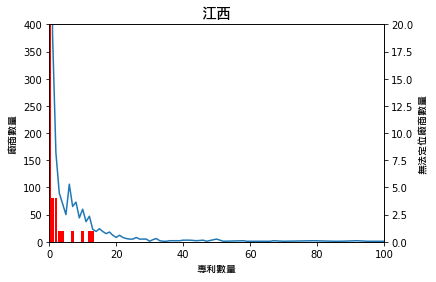

In [15]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count())
ax1.set_title('江西',fontproperties=myfont,fontsize=15)
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)
ax1.set_xlim([0,100])
ax1.set_ylim([0,400])
ax2 = ax1.twinx()
ax2.bar(merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count(),color='red')
ax2.set_ylim([0,20])
ax2.set_ylabel('無法定位廠商數量',fontproperties=myfont)


In [3]:
region = pd.read_excel(r'E:\paper\清理結果-新園區內外\江西_結果.xlsx',index_col=0)
region.fillna('',inplace=True)
corptype = ['有限','责任','集团','股份','控股','总公司','分公司','公司']
region['name_clean'] = region['name']
for k in corptype:
    region['name_clean'] = region['name_clean'].map(lambda x:re.sub(k,'',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'[\s+-─]','',x))
clean = region[region.duplicated(['name_clean'],keep=False)].sort_values(by=['企業名稱'])
patents = clean.groupby('name_clean')['專利數'].sum()
final = clean.drop('專利數',axis=1).merge(patents,left_on='name_clean',right_on='name_clean',how='left')
final.drop_duplicates(['name_clean'],keep='last',inplace=True)
region.drop_duplicates(['name_clean'],keep=False,inplace=True)
cleaned = pd.concat([region,final],ignore_index=True,sort=False)
located = cleaned[cleaned['lat']!='']
not_merge = located[located['企業名稱']=='']
print(len(not_merge['專利數']))
print(len(not_merge['專利數'])/len(located['專利數']))
print(len(not_merge[not_merge['專利數']>100]['專利數']))

393
0.0534985025864416
4


In [4]:
not_merge.groupby('專利數')['IPC'].count()

專利數
1      144
2       60
3       33
4       23
5       14
6       11
7        5
8        9
9        4
10       7
11       7
12      11
13       6
14       3
15       5
16       5
17       5
18       4
19       2
21       4
22       1
23       1
24       1
26       2
27       1
29       2
30       1
31       2
32       1
35       1
36       1
38       2
46       2
50       1
59       1
66       1
67       2
70       1
79       1
92       1
96       1
170      1
224      1
328      1
615      1
Name: IPC, dtype: int64

In [5]:
not_merge[not_merge['專利數']>=100].sort_values('專利數')

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str,序号,标题,文献页数,合享价值度,链接到incoPat,公开（公告）号,公开（公告）日,申请号,申请日,标准化申请人,申请人国别代码,申请人省市代码,中国申请人地市,中国申请人区县,申请人地址,申请人类型,优先权信息,权利要求数量,专利类型,...,简单同族个数,扩展同族个数,inpadoc同族个数,引证专利,被引证专利,被引证次数,引证科技文献,专利寿命（月）,被引证国别(forward),失效日,公开国别,申请人,name,address,完整地址,lat,lnt,南昌,新余,景德鎮,鷹潭,早期園區,近期園區,專利數,name_clean
7335,,,,,,,2366,摄像头模组自动对焦功能测试方法,7,5,到incoPat中查看\r\nCN103809368B,CN103809368B,2016-04-06 00:00:00,CN201210457418.6,2012-11-14 00:00:00,[欧菲光司-C],中国,江西; 36,[南昌],[新建],江西省南昌市南昌经济技术开发区丁香路以东、龙潭水渠以北南昌欧菲光电技术有限公司,企业,,6,发明授权,...,2,2,2,CN101833234A; JP2012149928A; CN101144966A; CN101153951A; CN101034240A,,0,,72,,2018-11-14 00:00:00,CN,南昌欧菲光电技术有限公司,南昌欧菲光电技术有限公司,江西省南昌市南昌经济技术开发区丁香路以东、龙潭水渠以北南昌欧菲光电技术有限公司,0,28.7349,115.841,17.469950,131.379168,143.140951,127.281695,0,0,170,南昌欧菲光电技术
7364,,,,,,,2178,硅整流自动控制装置,6,9,到incoPat中查看\r\nCN103057438B,CN103057438B,2016-04-27 00:00:00,CN201210588839.2,2012-12-31 00:00:00,[江钨集团-C],中国,江西; 36,[南昌],[东湖],江西省南昌市北京西路118号,企业,,1,发明授权,...,2,2,2,CN87215773U; CN2099698U; GB2289997A; JP2006234461A; CN202475286U; CN2589257Y; CN202966005U; JP2009241677A; EP1892141A1,,0,,,,,CN,江西稀有稀土金属钨业集团有限公司,江西稀有稀土金属钨业集团有限公司,江西省南昌市北京西路118号,1,28.6737,115.91,9.475899,130.914573,140.126793,118.240048,1,0,224,江西稀有稀土金属钨业
7365,,,,,,,8589,钒的浸出方法,12,9,到incoPat中查看\r\nCN103060551B,CN103060551B,2015-01-21 00:00:00,CN201210590772.6,2012-12-31 00:00:00,[中国有色-C],中国,江西; 36,[南昌],,江西省南昌市红角洲前湖大道888号,企业,,8,发明授权,...,2,2,2,CN101481755A; CN102059172A; CN101935755A,,0,,,,,CN,中国瑞林工程技术有限公司,中国瑞林工程技术有限公司,江西省南昌市红角洲前湖大道888号,1,28.6552,115.809,19.456122,122.690504,149.786853,126.419645,0,0,328,中国瑞林工程技术
7356,,,,,,,9876,一种真空袋/热压罐法制造复合材料件的抽真空装置,7,9,到incoPat中查看\r\nCN103057127B,CN103057127B,2014-12-17 00:00:00,CN201210552445.1,2012-12-19 00:00:00,[中航工业-C],中国,江西; 36,[南昌],[青云谱],江西省南昌市新溪桥5001信箱460分箱,企业,,7,发明授权,...,2,2,2,,,0,,0,,,CN,江西洪都航空工业集团有限责任公司,江西洪都航空工业集团有限责任公司,江西省南昌市新溪桥5001信箱460分箱,0,28.6829,115.858,14.546549,128.177514,144.128785,123.258943,0,0,615,江西洪都航空工业


Text(0.5, 0, '專利數量')

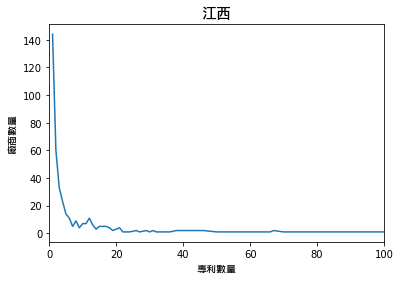

In [6]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(not_merge.groupby('專利數')['IPC'].count().index,not_merge.groupby('專利數')['IPC'].count())
ax1.set_title('江西',fontproperties=myfont,fontsize=15)
ax1.set_xlim([0,100])
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)

In [7]:
cleaned.to_excel(r'E:\paper\名稱merge\江西_結果.xlsx')

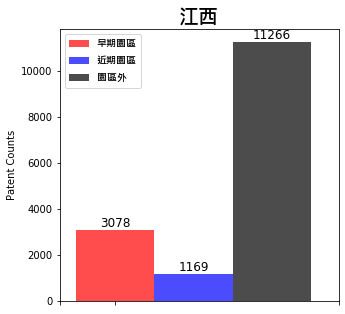

In [10]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, merge_df[merge_df['早期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['早期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, merge_df[merge_df['近期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['近期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), '%.0f' % merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  

plt.title('江西',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper left',prop=myfont)

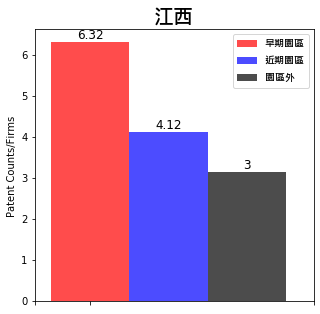

In [11]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts/Firms ')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), '%.0f' % (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  

plt.title('江西',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)